<a href="https://colab.research.google.com/github/annkvth/kompleteNetze/blob/main/03_international_robustness.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Notebook to process either our own extracted flightlists, or excerpts of the data from "Crowdsourced air traffic data from The OpenSky Network 2020",
https://zenodo.org/records/7923702


In [1]:
!pip install traffic

Include libraries

In [2]:
from datetime import datetime, timedelta
import pandas as pd
import networkx as nx

Always use python engine for dataframe queries, see
https://stackoverflow.com/questions/67063643/is-there-a-way-to-force-pandas-dataframe-query-to-use-python-as-default-engine

In [3]:
from functools import partialmethod

pd.DataFrame.query = partialmethod(pd.DataFrame.query, engine="python")



Mount google drive to get the csv files

In [4]:
from google.colab import drive
drive.mount('/content/drive')

import os

# where to save the data (and making shure that the directory exist)
folder_path = "/content/drive/My Drive/2024KomplexeNetze/Daten"
if not os.path.exists(folder_path):
    print(f'No such folder: {folder_path}')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


List all the csv files in the folder.

In [5]:
import glob

csv_files = glob.glob(os.path.join(folder_path, "*.csv"))
print(csv_files)

['/content/drive/My Drive/2024KomplexeNetze/Daten/2024-01-01_2024-04-01.csv', '/content/drive/My Drive/2024KomplexeNetze/Daten/2024-04-01_2024-07-01.csv', '/content/drive/My Drive/2024KomplexeNetze/Daten/2023-04-01_2023-07-01.csv', '/content/drive/My Drive/2024KomplexeNetze/Daten/2023-01-01_2023-04-01.csv', '/content/drive/My Drive/2024KomplexeNetze/Daten/2019-04-01_2019-07-01.csv', '/content/drive/My Drive/2024KomplexeNetze/Daten/2019-07-01_2019-10-01.csv', '/content/drive/My Drive/2024KomplexeNetze/Daten/2023-07-01_2023-10-01.csv', '/content/drive/My Drive/2024KomplexeNetze/Daten/2023-10-01_2024-01-01.csv', '/content/drive/My Drive/2024KomplexeNetze/Daten/2019-10-01_2020-01-01.csv', '/content/drive/My Drive/2024KomplexeNetze/Daten/2019-01-01_2019-04-01.csv', '/content/drive/My Drive/2024KomplexeNetze/Daten/2018-10-01_2019-01-01.csv', '/content/drive/My Drive/2024KomplexeNetze/Daten/2018-07-01_2018-10-01.csv', '/content/drive/My Drive/2024KomplexeNetze/Daten/2018-04-01_2018-07-01.csv'

Testing with a single file for now....
Read into a pandas dataframe.

In [6]:
flightdata = pd.read_csv(csv_files[0], parse_dates=["firstseen", "lastseen", "day"])

Quick check what we got from the file...

In [7]:
flightdata.head()

,icao24,firstseen,departure,lastseen,arrival,callsign,day
0,a2b8db,2024-01-01 12:51:18+00:00,EDDF,2024-01-01 23:17:07+00:00,KSFO,UAL59,2024-01-01 00:00:00+00:00
1,a2b8db,2023-12-31 22:41:04+00:00,KIAD,2024-01-01 05:37:14+00:00,EDDF,UAL989,2024-01-01 00:00:00+00:00
2,ac5fd6,2024-01-01 07:07:54+00:00,NaN,2024-01-01 15:01:39+00:00,EDDK,FDX5038,2024-01-01 00:00:00+00:00
3,3944ed,2024-01-01 17:34:31+00:00,EDDB,2024-01-01 18:57:40+00:00,LFPG,AFR45SP,2024-01-01 00:00:00+00:00
4,3944ed,2024-01-01 15:02:37+00:00,LFPG,2024-01-01 16:19:21+00:00,EDDB,AFR1834,2024-01-01 00:00:00+00:00


In [8]:
flightdata.describe()


,icao24,firstseen,departure,lastseen,arrival,callsign,day
count,325447,325244,292303,325447,301849,325394,325447
unique,9623,NaN,1085,NaN,1351,21520,NaN
top,3c4dc4,NaN,EDDF,NaN,EDDF,CHX76,NaN
freq,618,NaN,44315,NaN,47166,342,NaN
mean,NaN,2024-02-16 15:52:49.205042688+00:00,NaN,2024-02-16 18:09:24.255955968+00:00,NaN,NaN,2024-02-16 04:20:28.601891584+00:00
min,NaN,2023-12-31 05:41:46+00:00,NaN,2024-01-01 00:00:27+00:00,NaN,NaN,2024-01-01 00:00:00+00:00
25%,NaN,2024-01-25 07:14:44.249999872+00:00,NaN,2024-01-25 09:04:32.500000+00:00,NaN,NaN,2024-01-25 00:00:00+00:00
50%,NaN,2024-02-17 08:16:42+00:00,NaN,2024-02-17 10:10:50+00:00,NaN,NaN,2024-02-17 00:00:00+00:00
75%,NaN,2024-03-10 13:03:42.500000+00:00,NaN,2024-03-10 15:25:52+00:00,NaN,NaN,2024-03-10 00:00:00+00:00
max,NaN,2024-03-31 22:49:30+00:00,NaN,2024-03-31 22:59:52+00:00,NaN,NaN,2024-03-31 00:00:00+00:00


Check for empty fileds in the data - there seem to be a few...

In [9]:
nan_percentage = (flightdata.isna().sum() / len(flightdata)) * 100
print(nan_percentage)

icao24        0.000000
firstseen     0.062376
departure    10.184147
lastseen      0.000000
arrival       7.250950
callsign      0.016285
day           0.000000
dtype: float64


Should we drop this data? Spend more time figuring out where it comes from? (e.g. if there is another entry with the same callsign and time, but complete)

In [10]:
flightdata.dropna(inplace=True)
flightdata.describe()

,icao24,firstseen,departure,lastseen,arrival,callsign,day
count,268679,268679,268679,268679,268679,268679,268679
unique,9180,NaN,1085,NaN,1351,18779,NaN
top,3c4dc4,NaN,EDDF,NaN,EDDF,CHX76,NaN
freq,580,NaN,38321,NaN,37137,310,NaN
mean,NaN,2024-02-16 17:12:01.839957248+00:00,NaN,2024-02-16 19:19:05.888182272+00:00,NaN,NaN,2024-02-16 05:23:45.601553920+00:00
min,NaN,2023-12-31 08:57:16+00:00,NaN,2024-01-01 00:00:27+00:00,NaN,NaN,2024-01-01 00:00:00+00:00
25%,NaN,2024-01-25 12:12:01.500000+00:00,NaN,2024-01-25 14:16:04.500000+00:00,NaN,NaN,2024-01-25 00:00:00+00:00
50%,NaN,2024-02-17 11:01:47+00:00,NaN,2024-02-17 13:05:57+00:00,NaN,NaN,2024-02-17 00:00:00+00:00
75%,NaN,2024-03-10 09:42:37.500000+00:00,NaN,2024-03-10 11:36:34.500000+00:00,NaN,NaN,2024-03-10 00:00:00+00:00
max,NaN,2024-03-31 22:49:30+00:00,NaN,2024-03-31 22:59:52+00:00,NaN,NaN,2024-03-31 00:00:00+00:00


----


In [11]:
from traffic.data import airports
import altair as alt

Add city names to the airports

In [12]:
flightdata=flightdata.merge(airports.data[["icao", "municipality"]], left_on="departure", right_on="icao", how="left", )
flightdata = flightdata.rename(columns={"municipality": "departure_city"})
flightdata=flightdata.merge(airports.data[["icao", "municipality"]], left_on="arrival", right_on="icao", how="left", )
flightdata = flightdata.rename(columns={"municipality": "arrival_city"})



In [13]:
# add a column to flightdata dataframe with contains week-and-year
flightdata['week_and_year'] = flightdata['day'].dt.strftime('%Y-%U')
flightdata.tail()


,icao24,firstseen,departure,lastseen,arrival,callsign,day,icao_x,departure_city,icao_y,arrival_city,week_and_year
268674,3c675a,2024-03-31 10:07:05+00:00,EDDF,2024-03-31 11:18:55+00:00,EPWA,DLH1348,2024-03-31 00:00:00+00:00,EDDF,Frankfurt am Main,EPWA,Warsaw,2024-13
268675,3c675a,2024-03-31 08:02:30+00:00,LFPG,2024-03-31 08:44:43+00:00,EDDF,DLH1027,2024-03-31 00:00:00+00:00,LFPG,"Paris (Roissy-en-France, Val-d'Oise)",EDDF,Frankfurt am Main,2024-13
268676,3c675a,2024-03-31 05:33:05+00:00,EDDF,2024-03-31 06:23:57+00:00,LFPG,DLH1026,2024-03-31 00:00:00+00:00,EDDF,Frankfurt am Main,LFPG,"Paris (Roissy-en-France, Val-d'Oise)",2024-13
268677,3c70c7,2024-03-31 09:10:32+00:00,KORD,2024-03-31 17:27:33+00:00,EDDF,GEC8185,2024-03-31 00:00:00+00:00,KORD,Chicago,EDDF,Frankfurt am Main,2024-13
268678,3e017a,2024-03-31 10:44:00+00:00,EDAR,2024-03-31 10:56:52+00:00,EDDC,CHX38,2024-03-31 00:00:00+00:00,EDAR,Pirna,EDDC,Dresden,2024-13


In [14]:
# add a column to flightdata dataframe with contains month-and-year
flightdata['month_and_year'] = flightdata['day'].dt.strftime('%Y-%m')
flightdata.tail()

,icao24,firstseen,departure,lastseen,arrival,callsign,day,icao_x,departure_city,icao_y,arrival_city,week_and_year,month_and_year
268674,3c675a,2024-03-31 10:07:05+00:00,EDDF,2024-03-31 11:18:55+00:00,EPWA,DLH1348,2024-03-31 00:00:00+00:00,EDDF,Frankfurt am Main,EPWA,Warsaw,2024-13,2024-03
268675,3c675a,2024-03-31 08:02:30+00:00,LFPG,2024-03-31 08:44:43+00:00,EDDF,DLH1027,2024-03-31 00:00:00+00:00,LFPG,"Paris (Roissy-en-France, Val-d'Oise)",EDDF,Frankfurt am Main,2024-13,2024-03
268676,3c675a,2024-03-31 05:33:05+00:00,EDDF,2024-03-31 06:23:57+00:00,LFPG,DLH1026,2024-03-31 00:00:00+00:00,EDDF,Frankfurt am Main,LFPG,"Paris (Roissy-en-France, Val-d'Oise)",2024-13,2024-03
268677,3c70c7,2024-03-31 09:10:32+00:00,KORD,2024-03-31 17:27:33+00:00,EDDF,GEC8185,2024-03-31 00:00:00+00:00,KORD,Chicago,EDDF,Frankfurt am Main,2024-13,2024-03
268678,3e017a,2024-03-31 10:44:00+00:00,EDAR,2024-03-31 10:56:52+00:00,EDDC,CHX38,2024-03-31 00:00:00+00:00,EDAR,Pirna,EDDC,Dresden,2024-13,2024-03


Generate the list of international airpots = airports not in my icaolist

Load the flightdata into networkx


In [16]:
# Create a directed graph
trafficgraph = nx.DiGraph()

icaolist=["EDBH", "EDDB", "EDVE", "EDDW", "ETMN", "EDLW", "EDDC", "EDDL", "EDDE", "EDDF", "EDFH", "EDNY", "EDDH", "EDDV", "EDAH", "ETSI", "EDSB", "EDVK",
           "EDDK", "EDTL", "EDDP", "EDHL", "EDBC", "EDJA", "EDDM", "EDDG", "EDBN", "EDLV", "EDDN", "EDMO", "EDLP", "ETNL", "EDDR", "EDGS", "EDDS", "EDXW"]

# query dataframe for everything starting/ending at one of the selected airports, just in case we add more non-German data later
flightdata = flightdata[flightdata['departure'].isin(icaolist) | flightdata['arrival'].isin(icaolist)]

# Add nodes and edges from the flights data
for index, row in flightdata.iterrows():
    origin = row['departure']
    destination = row['arrival']

    # Add the origin and destination as nodes if they don't exist
    if origin not in trafficgraph:
        trafficgraph.add_node(origin)
    if destination not in trafficgraph:
        trafficgraph.add_node(destination)

    # Add an edge from origin to destination, with optional attributes
    trafficgraph.add_edge(origin,destination)

    # note: for weighted graph, add number of connections as edge weights later?

# Optional: Inspect the graph
print("Number of nodes (airports):", trafficgraph.number_of_nodes())
print("Number of edges (flights):", trafficgraph.number_of_edges())



Number of nodes (airports): 1516
Number of edges (flights): 11828


In [17]:
international_list = flightdata[~flightdata['arrival'].isin(icaolist)]['arrival'].unique()

print (f'Found {len(international_list)} international airports to check against')

Found 1315 international airports to check against


do the same as a weighted graph, using frequency of connections as edge weight inside Germany (note: I tried to have it for all edges, but that appears to be very computation-intensive.)

In [18]:
weightedgraph = nx.DiGraph()

# Part 1: Add nodes from the flights data
for index, row in flightdata.iterrows():
    origin = row['departure']
    destination = row['arrival']

    # Add the origin and destination as nodes if they don't exist
    if origin not in weightedgraph:
        weightedgraph.add_node(origin)
    if destination not in weightedgraph:
        weightedgraph.add_node(destination)


print("Number of nodes (airports):", weightedgraph.number_of_nodes())

Number of nodes (airports): 1516


In [19]:
# Part 2: Add weighted edges from the flights data

# Group flights by origin, destination, and day to count weekly connections
weekly_connections = flightdata.groupby(['departure', 'arrival', 'week_and_year']).size().reset_index(name='connections')
print(weekly_connections.tail())
average_connections = weekly_connections.groupby(['departure', 'arrival'])['connections'].mean().reset_index()
print(average_connections.tail())

# Group flights by origin, destination, and day to count monthly connections
#monthly_connections = flightdata.groupby(['departure', 'arrival', 'month_and_year']).size().reset_index(name='connections')
#print(monthly_connections.tail())

# Calculate the average connections for each departure-arrival combination
#average_connections = monthly_connections.groupby(['departure', 'arrival'])['connections'].mean().reset_index()
#print(average_connections.tail())

      departure arrival week_and_year  connections
44535      ZGSZ    EDDP       2024-04            5
44536      ZGSZ    EDDP       2024-05            4
44537      ZGSZ    EDDP       2024-07            4
44538      ZGSZ    EDDP       2024-08            6
44539      ZGSZ    EDDP       2024-09            5
      departure arrival  connections
11823      ZGSZ    EDDB     1.000000
11824      ZGSZ    EDDF     4.416667
11825      ZGSZ    EDDK     1.000000
11826      ZGSZ    EDDM     1.250000
11827      ZGSZ    EDDP     4.111111


In [20]:
# Add weighted edges based on average connections
for index, row in average_connections.iterrows():
    origin = row['departure']
    destination = row['arrival']
    weight = row['connections']

    # Add the edge with the calculated weight
    if origin in weightedgraph and destination in weightedgraph:
        weightedgraph.add_edge(origin, destination, weight=weight)


print("Number of edges (flights):", weightedgraph.number_of_edges())

Number of edges (flights): 11828


------------------------------------------

Zhou et al, 2021: International efficiency (equation 2)
This requires the shortest path between node i and j - use networkx to get that

To get the recirpocal of the shortest path, determine that using
single_source_all_shortest_paths
for every departure airport in Germany, to any listed arrival airport that is not in my list of German airports

In [21]:
total_reciprocal_shortest_paths = {}

for icao in icaolist:
  total_reciprocal_shortest_path_for_icao = 0
  shortest_paths = nx.single_source_shortest_path_length(trafficgraph, source=icao)
  for arrival_airport in international_list:
    if arrival_airport in shortest_paths:
      total_reciprocal_shortest_path_for_icao += 1/shortest_paths[arrival_airport]
  total_reciprocal_shortest_paths[icao] = total_reciprocal_shortest_path_for_icao

#print(total_reciprocal_shortest_paths)

sum_of_reciprocals = sum(total_reciprocal_shortest_paths.values())
IE = sum_of_reciprocals * 1/(len(international_list) * len(icaolist))
print(f"The international effiency of the given flight data is: {IE}")

The international effiency of the given flight data is: 0.5363431206872273



Turn the cell above into a function, that can be called with a different graph instead of trafficgraph



In [22]:
# prompt: please modify the function in the cell above so that the argument is a graph object, not the name of a graph

def analyze_graph_IE(graph):
    """
    Analyzes the specified graph and calculates international efficiency.

    Args:
        graph (nx.DiGraph): The graph object to analyze.
    """
    try:
      # code to calculate international efficiency using the graph
      total_reciprocal_shortest_paths = {}

      for icao in icaolist:
        if icao in graph: # Check if icao is in the graph
          total_reciprocal_shortest_path_for_icao = 0
          shortest_paths = nx.single_source_shortest_path_length(graph, source=icao)
          for arrival_airport in international_list:
              if arrival_airport in shortest_paths:
                  total_reciprocal_shortest_path_for_icao += 1/shortest_paths[arrival_airport]
          total_reciprocal_shortest_paths[icao] = total_reciprocal_shortest_path_for_icao

      sum_of_reciprocals = sum(total_reciprocal_shortest_paths.values())
      IE = sum_of_reciprocals * 1/(len(international_list) * len(icaolist))
      #print(f"The international effiency of the given graph is: {IE}")

      return IE

    except KeyError as e:
      print(f"Error: {e}")
    except Exception as e:
        print(f"An error occurred: {e}")


# Test usage:
analyze_graph_IE(trafficgraph) # analyze the trafficgraph variable
analyze_graph_IE(weightedgraph) # analyze the weightedgraph variable

0.5363431206872273

Next step: the weighted international efficiency WIE.

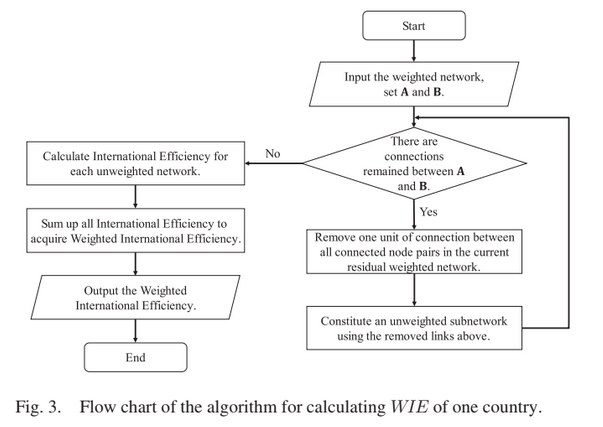

New graph, containing only flights with origin in Germany

In [23]:
inputgraph = nx.DiGraph()
for u, v, data in weightedgraph.edges(data=True):
  if u in icaolist:
    inputgraph.add_edge(u, v, **data) # Keep the edge data/weight
print("Number of edges (flights):", inputgraph.number_of_edges())


Number of edges (flights): 6771


for the inputgraph network above, create a subgraph in which each edge has the weight one, and reduce the weight of all edges in input graph by one. if the weight of an edge is 0 or less, remove that edge. repeat these steps until no more edges remain in inputgraph.


In [24]:
def process_graph(inputgraph, icaolist):
  """
  Processes the input graph by creating subgraphs, reducing edge weights, and removing edges
  until no more destination nodes remain in the inputgraph that are not part of icaolist.
  """

  subgraph_list = []

  while True:
      # Check if there are any destination nodes left that are not in icaolist
      destination_nodes_outside_icaolist = False
      for u, v, data in inputgraph.edges(data=True):
        if v not in icaolist:
            destination_nodes_outside_icaolist = True
            break

      if not destination_nodes_outside_icaolist or inputgraph.number_of_edges() == 0:
        break

      subgraph = nx.DiGraph()
      for u, v, data in inputgraph.edges(data=True):
          subgraph.add_edge(u, v, weight=1)

      subgraph_list.append(subgraph)

      edges_to_remove = []
      for u, v, data in inputgraph.edges(data=True):
          new_weight = data.get('weight', 1) - 1
          if new_weight <= 0:
              edges_to_remove.append((u, v))
          else:
              inputgraph[u][v]['weight'] = new_weight

      inputgraph.remove_edges_from(edges_to_remove)

  print("Subgraph history length:", len(subgraph_list))
  return subgraph_list

#Call the function, passing the icaolist ("backing up" the input graph first)
german_origin_graph = inputgraph.copy()
decomposed_subgraphs = process_graph(inputgraph, icaolist)

Subgraph history length: 97


The weighted international efficiency is the sum of the IE of all those subgraphs

In [25]:
total_ie = 0
for subnet in decomposed_subgraphs:
  ie = analyze_graph_IE(subnet)
  total_ie += ie

print("Weighted International Efficiency:", total_ie)

Weighted International Efficiency: 1.1392751020982985


--------------------------
To clarify: what is the "number of connections between i and j" - per day, month, year, average?

Using per month I get WIE=3, using the average per week I get WIE=1.14 for 2024-01-01_2024-04-01.csv

In the Zhou 2021 paper they have 1.5 for Germany, but don't specify which "number of connections" they use.
... or maybe it doesn't matter, as long as we keep the same timeframe as base for comparisons.

In [26]:
# based on the cell above, make a function that takes a graph as an input and determines the total_ie

def analyze_graph_WIE(graph):
    """
    Calculates the weighted international efficiency (WIE) of a given graph.

    Args:
        graph: A NetworkX DiGraph representing the network.

    Returns:
        The weighted international efficiency (WIE) of the graph.
    """

    decomposed_subgraphs = process_graph(graph, icaolist)

    total_ie = 0
    for subnet in decomposed_subgraphs:
      ie = analyze_graph_IE(subnet)
      total_ie += ie
    return total_ie

# make a copy of german_origin_graph to test
mytestgraph = german_origin_graph.copy()
analyze_graph_WIE(mytestgraph)

Subgraph history length: 97


1.1392751020982985

---------------------------------------


Step 1 for international robustness:
remove the airport with the highest number of international connections

In [27]:
def remove_highest_degree_node(graph, icaolist):
    """
    Finds the node in the icaolist with the highest degree (number of edges)
    in the given graph and removes it.

    Args:
        graph: The input graph (NetworkX DiGraph).
        icaolist: A list of airport ICAO codes.

    Returns:
        A new graph with the highest-degree node removed.
        Returns the original graph if icaolist is empty or no nodes from the list are in the graph
    """

    # Create a subgraph containing only nodes from the icaolist
    subgraph = graph.subgraph(icaolist)

    if not subgraph.nodes():
      return graph

    # Find the node with the highest degree in the subgraph
    highest_degree_node = max(subgraph.degree, key=lambda x: x[1])[0]

    # Create a copy of the graph to avoid modifying the original
    modified_graph = graph.copy()

    # Remove the node and its connected edges from the modified graph
    modified_graph.remove_node(highest_degree_node)

    return modified_graph

# Example usage (assuming you have german_origin_graph and icaolist defined):
# Make a copy to avoid modifying the original graph
modified_graph = remove_highest_degree_node(german_origin_graph.copy(), icaolist)

# Now 'modified_graph' contains the graph with the highest-degree node removed.
# Let's see what the WIE is now...
analyze_graph_WIE(modified_graph.copy())

Subgraph history length: 97


1.0762910153499532

call the function remove_highest_degree_node iteratively on the output graph, until the returned graph does not contain any nodes that are part of icaolist.
While doing that, calculate the ratio of post- and pre- WIEs.

In [28]:
modified_graph = german_origin_graph.copy()
sum_ratio = 0
WIE_pre = analyze_graph_WIE(modified_graph.copy())
while True:
    nodes_in_icaolist = [node for node in modified_graph.nodes if node in icaolist]
    if not nodes_in_icaolist:
        break
    modified_graph = remove_highest_degree_node(modified_graph, icaolist)
    WIE_post=analyze_graph_WIE(modified_graph.copy())
    ratio = WIE_post/WIE_pre
    #print("Ratio:", ratio)
    WIE_pre = WIE_post
    sum_ratio += ratio

print("International robustness:", sum_ratio/len(icaolist))


Subgraph history length: 97
Subgraph history length: 97
Subgraph history length: 97
Subgraph history length: 97
Subgraph history length: 97
Subgraph history length: 97
Subgraph history length: 97
Subgraph history length: 97
Subgraph history length: 97
Subgraph history length: 97
Subgraph history length: 97
Subgraph history length: 97
Subgraph history length: 97
Subgraph history length: 97
Subgraph history length: 97
Subgraph history length: 97
Subgraph history length: 97
Subgraph history length: 97
Subgraph history length: 97
Subgraph history length: 32
Subgraph history length: 32
Subgraph history length: 8
Subgraph history length: 8
Subgraph history length: 8
Subgraph history length: 8
Subgraph history length: 8
Subgraph history length: 8
Subgraph history length: 8
Subgraph history length: 8
Subgraph history length: 8
Subgraph history length: 5
Subgraph history length: 5
Subgraph history length: 5
Subgraph history length: 1
Subgraph history length: 1
Subgraph history length: 1
Subgrap